<a href="https://colab.research.google.com/github/scottspurlock/noisy_labels/blob/main/autoencoder_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Adding a classification head to an autoencoder

Adapted from
- Autoencoder tutorial: https://learnopencv.com/autoencoder-in-tensorflow-2-beginners-guide/

Created: 5/26/2021

Adds a separate classification head to an autoencoder to allow latent representation to be classified.

In [ ]:
import time

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K

from IPython import display


In [ ]:
num_classes = 10
input_shape = (28, 28, 1)

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

In [ ]:
# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255

# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

print("x_train shape:", x_train.shape)
print("x_test shape:", x_test.shape)


# One-hot encode the labels
y_train_one_hot = keras.utils.to_categorical(y_train, num_classes)
y_test_one_hot = keras.utils.to_categorical(y_test, num_classes)

print('y_train shape:', y_train.shape)
print('y_train_one_hot shape:', y_train.shape)

x_train shape: (60000, 28, 28, 1)
x_test shape: (10000, 28, 28, 1)
y_train shape: (60000,)
y_train_one_hot shape: (60000,)


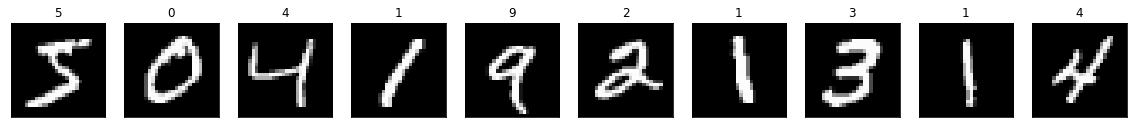

In [ ]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(1, n, i + 1)
  plt.imshow(x_train[i, :, :, 0])
  plt.title('{}'.format(y_train[i]))
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

plt.show()

In [ ]:
batch_size = 128
epochs = 10
latent_dim = 2
n_train = x_train.shape[0]

In [ ]:
def encoder(input_encoder):
    
    inputs = keras.Input(shape=input_encoder, name='input_layer')
    # Block 1
    x = layers.Conv2D(32, kernel_size=3, strides= 1, padding='same', name='conv_1')(inputs)
    x = layers.BatchNormalization(name='bn_1')(x)
    x = layers.LeakyReLU(name='lrelu_1')(x)
   
    # Block 2
    x = layers.Conv2D(64, kernel_size=3, strides= 2, padding='same', name='conv_2')(x)
    x = layers.BatchNormalization(name='bn_2')(x)
    x = layers.LeakyReLU(name='lrelu_2')(x)
   
    # Block 3
    x = layers.Conv2D(64, 3, 2, padding='same', name='conv_3')(x)
    x = layers.BatchNormalization(name='bn_3')(x)
    x = layers.LeakyReLU(name='lrelu_3')(x)
    
    # Block 4
    x = layers.Conv2D(64, 3, 1, padding='same', name='conv_4')(x)
    x = layers.BatchNormalization(name='bn_4')(x)
    x = layers.LeakyReLU(name='lrelu_4')(x)
    
    # Final Block
    flatten = layers.Flatten()(x)
    # bottleneck = layers.Dense(latent_dim, name='latent_out', kernel_regularizer='l1')(flatten)
    bottleneck = layers.Dense(latent_dim, name='latent_out')(flatten)
    model = tf.keras.Model(inputs, bottleneck, name="Encoder")

    return model

In [ ]:
def decoder(input_decoder):
    # Initial Block
    inputs = keras.Input(shape=input_decoder, name='input_layer')
    x = layers.Dense(3136, name='dense_1')(inputs)
    x = tf.reshape(x, [-1, 7, 7, 64], name='Reshape_Layer')
    
    # Block 1
    x = layers.Conv2DTranspose(64, 3, strides= 1, padding='same',name='conv_transpose_1')(x)
    x = layers.BatchNormalization(name='bn_1')(x)
    x = layers.LeakyReLU(name='lrelu_1')(x)
    
    # Block 2
    x = layers.Conv2DTranspose(64, 3, strides= 2, padding='same', name='conv_transpose_2')(x)
    x = layers.BatchNormalization(name='bn_2')(x)
    x = layers.LeakyReLU(name='lrelu_2')(x)
   
    # Block 3
    x = layers.Conv2DTranspose(32, 3, 2, padding='same', name='conv_transpose_3')(x)
    x = layers.BatchNormalization(name='bn_3')(x)
    x = layers.LeakyReLU(name='lrelu_3')(x)
   
    # Block 4
    outputs = layers.Conv2DTranspose(1, 3, 1,padding='same', activation='sigmoid', name='recon_out')(x)
    model = tf.keras.Model(inputs, outputs, name="Decoder")
    return model

In [ ]:
def classifier(input_classifier):
    inputs = keras.Input(shape=input_classifier, name='input_layer')
    x = layers.Dense(100, name='dense_1', activation='relu')(inputs)
    x = layers.Dense(100, name='dense_2', activation='relu')(x)
    outp = layers.Dense(num_classes, activation="softmax", name='classifier_out')(x)
    model = tf.keras.Model(inputs, outp, name="Classifier")

    return model

In [ ]:
enc = encoder(input_shape)
enc.summary()

Model: "Encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
bn_1 (BatchNormalization)    (None, 28, 28, 32)        128       
_________________________________________________________________
lrelu_1 (LeakyReLU)          (None, 28, 28, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 14, 14, 64)        18496     
_________________________________________________________________
bn_2 (BatchNormalization)    (None, 14, 14, 64)        256       
_________________________________________________________________
lrelu_2 (LeakyReLU)          (None, 14, 14, 64)        0   

In [ ]:
latent_size = enc.output_shape[1]
dec = decoder(latent_size)
dec.summary()

Model: "Decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 2)]               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3136)              9408      
_________________________________________________________________
tf.reshape (TFOpLambda)      (None, 7, 7, 64)          0         
_________________________________________________________________
conv_transpose_1 (Conv2DTran (None, 7, 7, 64)          36928     
_________________________________________________________________
bn_1 (BatchNormalization)    (None, 7, 7, 64)          256       
_________________________________________________________________
lrelu_1 (LeakyReLU)          (None, 7, 7, 64)          0         
_________________________________________________________________
conv_transpose_2 (Conv2DTran (None, 14, 14, 64)        3692

In [ ]:
latent_size = enc.output_shape[1]
cls = classifier(latent_size)
cls.summary()

Model: "Classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 2)]               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               300       
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
classifier_out (Dense)       (None, 10)                1010      
Total params: 11,410
Trainable params: 11,410
Non-trainable params: 0
_________________________________________________________________


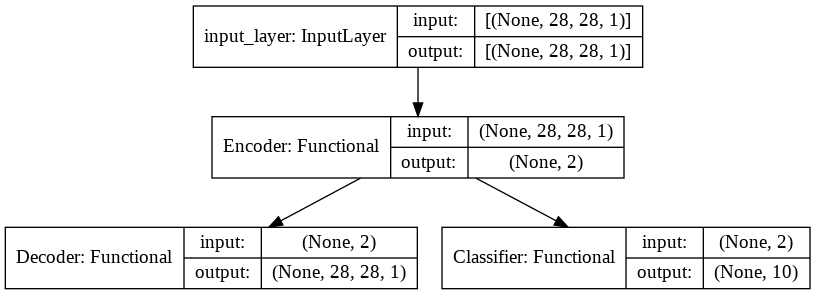

In [ ]:
inputs = keras.Input(shape=input_shape, name='input_layer')

model = tf.keras.Model(
			inputs=inputs,
			outputs=[dec(enc(inputs)), cls(enc(inputs))],
			name="autoclassnet")

# plot the autoencoder
tf.keras.utils.plot_model(model, 'autoencoder_classifier.png', show_shapes=True)

In [ ]:
losses = {
    'Decoder': 'mse',
    'Classifier': 'categorical_crossentropy',
}

wts = {
    'Decoder': 1.0, 
    'Classifier': 1.0
}

opt = keras.optimizers.Adam(learning_rate=5e-4)
model.compile(optimizer=opt, loss=losses, loss_weights=wts, metrics=["accuracy"])
hist = model.fit(x_train, [x_train, y_train_one_hot], batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/10
422/422 [==============================] - 14s 25ms/step - loss: 0.8068 - Decoder_loss: 0.0620 - Classifier_loss: 0.7448 - Decoder_accuracy: 0.7892 - Classifier_accuracy: 0.7341 - val_loss: 0.4390 - val_Decoder_loss: 0.0532 - val_Classifier_loss: 0.3858 - val_Decoder_accuracy: 0.7940 - val_Classifier_accuracy: 0.8755
Epoch 2/10
422/422 [==============================] - 10s 24ms/step - loss: 0.3917 - Decoder_loss: 0.0533 - Classifier_loss: 0.3385 - Decoder_accuracy: 0.7954 - Classifier_accuracy: 0.8950 - val_loss: 0.2624 - val_Decoder_loss: 0.0516 - val_Classifier_loss: 0.2109 - val_Decoder_accuracy: 0.7913 - val_Classifier_accuracy: 0.9380
Epoch 3/10
422/422 [==============================] - 10s 24ms/step - loss: 0.3189 - Decoder_loss: 0.0528 - Classifier_loss: 0.2661 - Decoder_accuracy: 0.7956 - Classifier_accuracy: 0.9177 - val_loss: 0.2560 - val_Decoder_loss: 0.0512 - val_Classifier_loss: 0.2048 - val_Decoder_accuracy: 0.7944 - val_Classifier_accuracy: 0.9368
Epoch 4/10

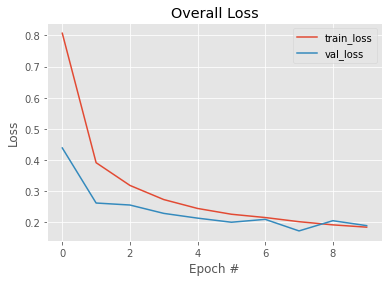

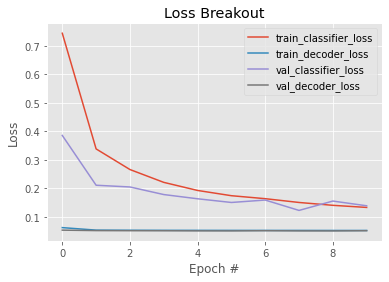

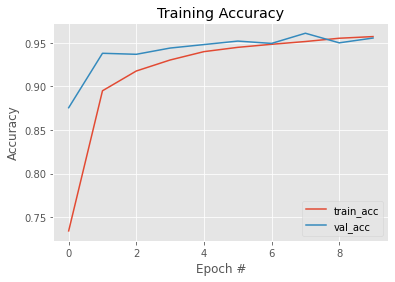

In [ ]:
# construct a plot that plots and saves the training history
plt.style.use("ggplot")
plt.figure()
plt.plot(hist.epoch, hist.history["loss"], label="train_loss")
plt.plot(hist.epoch, hist.history["val_loss"], label="val_loss")
plt.title("Overall Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()
plt.savefig('total_loss.png')
plt.show()

plt.figure()
plt.plot(hist.epoch, hist.history["Classifier_loss"], label="train_classifier_loss")
plt.plot(hist.epoch, hist.history["Decoder_loss"], label="train_decoder_loss")
plt.plot(hist.epoch, hist.history["val_Classifier_loss"], label="val_classifier_loss")
plt.plot(hist.epoch, hist.history["val_Decoder_loss"], label="val_decoder_loss")
plt.title("Loss Breakout")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()
plt.savefig('indiv_loss.png')
plt.show()

plt.figure()
plt.plot(hist.epoch, hist.history["Classifier_accuracy"], label="train_acc")
plt.plot(hist.epoch, hist.history["val_Classifier_accuracy"], label="val_acc")
plt.title("Training Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig('classifier_acc.png')
plt.show()



## Show some reconstructions

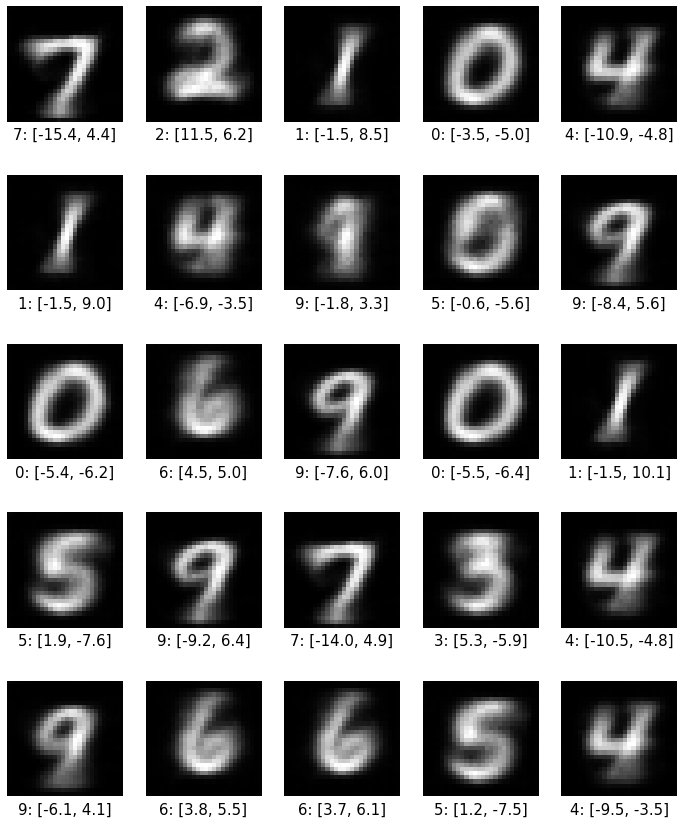

In [ ]:
figsize = 12

latent = enc.predict(x_test[:25])
reconst = dec.predict(latent)

fig = plt.figure(figsize=(figsize, 15))
#fig.subplots_adjust(wspace=-0.021)

for i in range(25):
    ax = fig.add_subplot(5, 5, i+1)
    ax.axis('off')
    plt.text(0.5, -0.15, '{}: [{:.1f}, {:.1f}]'.format(y_test[i], latent[i, 0], latent[i, 1]), fontsize=15, ha='center', transform=ax.transAxes)
    #plt.subplots_adjust(wspace=None, hspace=None)
    plt.imshow(reconst[i, :,:,0]*255, cmap = 'gray')
plt.show()

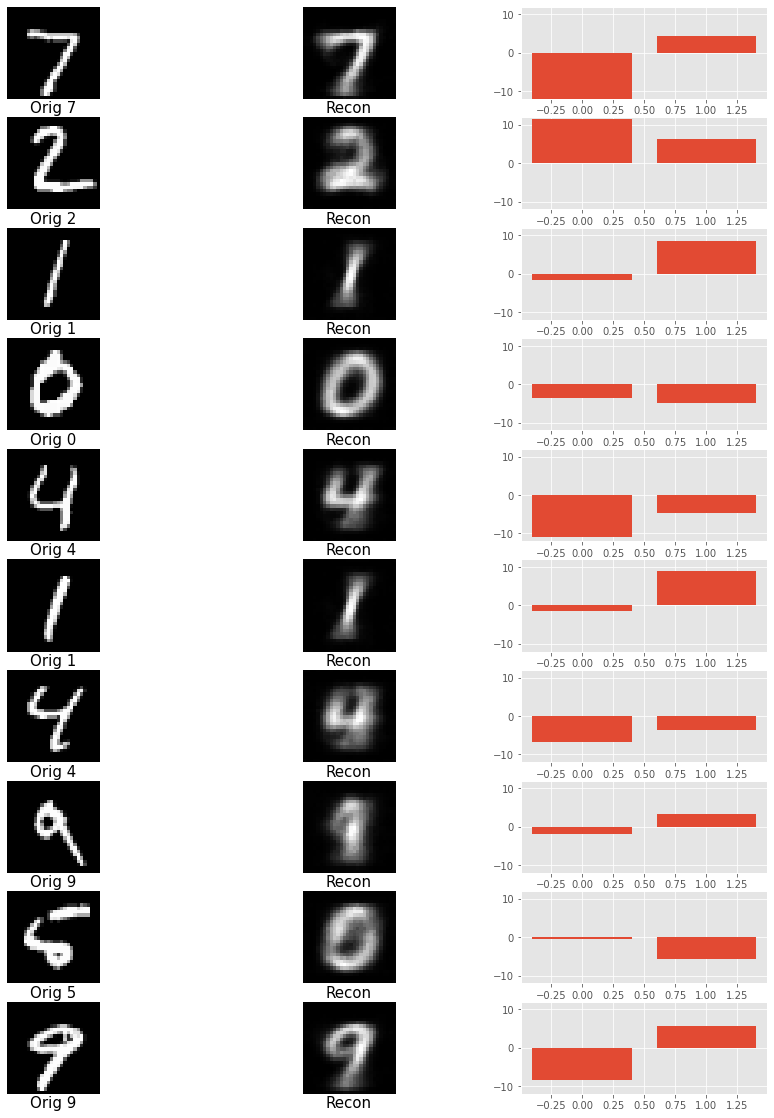

In [ ]:
figsize = 15

latent = enc.predict(x_test[:25])
reconst = dec.predict(latent)

fig = plt.figure(figsize=(figsize, 20))
#fig.subplots_adjust(wspace=-0.021)

for i in range(10):
    # Original
    ax = fig.add_subplot(10, 3, i*3+1)
    ax.axis('off')
    plt.text(0.5, -0.15, 'Orig ' + str(y_test[i]), fontsize=15, ha='center', transform=ax.transAxes)
    plt.imshow(x_test[i, :, :, 0]*255, cmap = 'gray')

    ax = fig.add_subplot(10, 3, i*3+2)
    ax.axis('off')
    plt.text(0.5, -0.15, 'Recon', fontsize=15, ha='center', transform=ax.transAxes)
    plt.imshow(reconst[i, :, :, 0]*255, cmap = 'gray')

    ax = fig.add_subplot(10, 3, i*3+3)
    plt.bar(np.arange(latent_size), latent[i])
    plt.ylim((-12, 12))

plt.show()

## Latent space projection

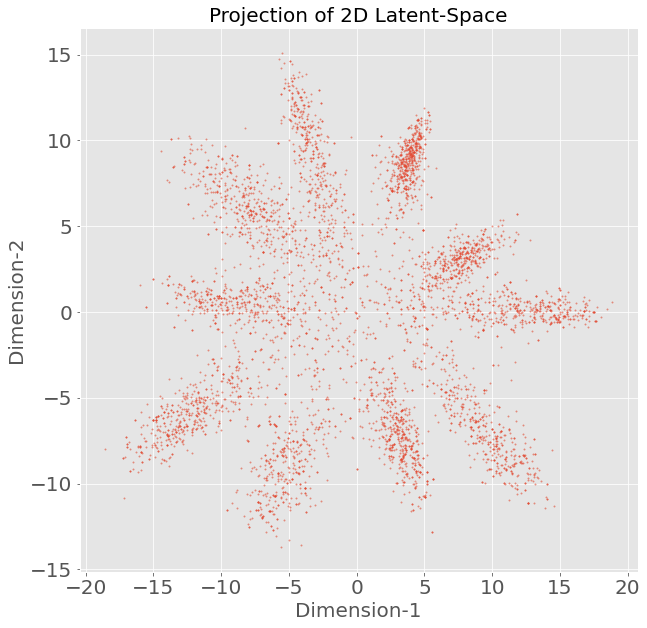

In [ ]:
from sklearn.decomposition import PCA

imgs_visualize = 5000
figsize = 10

index = np.random.choice(range(len(x_test)), imgs_visualize)
images = x_test[index]

embeddings = enc.predict(images)

pca = PCA(n_components=2)
pca.fit(embeddings)
embeddings = pca.transform(embeddings)

plt.figure(figsize=(figsize, figsize))
plt.scatter(embeddings[:, 0] , embeddings[:, 1], alpha=0.5, s=2)
plt.xlabel("Dimension-1", size=20)
plt.ylabel("Dimension-2", size=20)
plt.xticks(size=20)
plt.yticks(size=20)
plt.title("Projection of 2D Latent-Space", size=20)
plt.show()

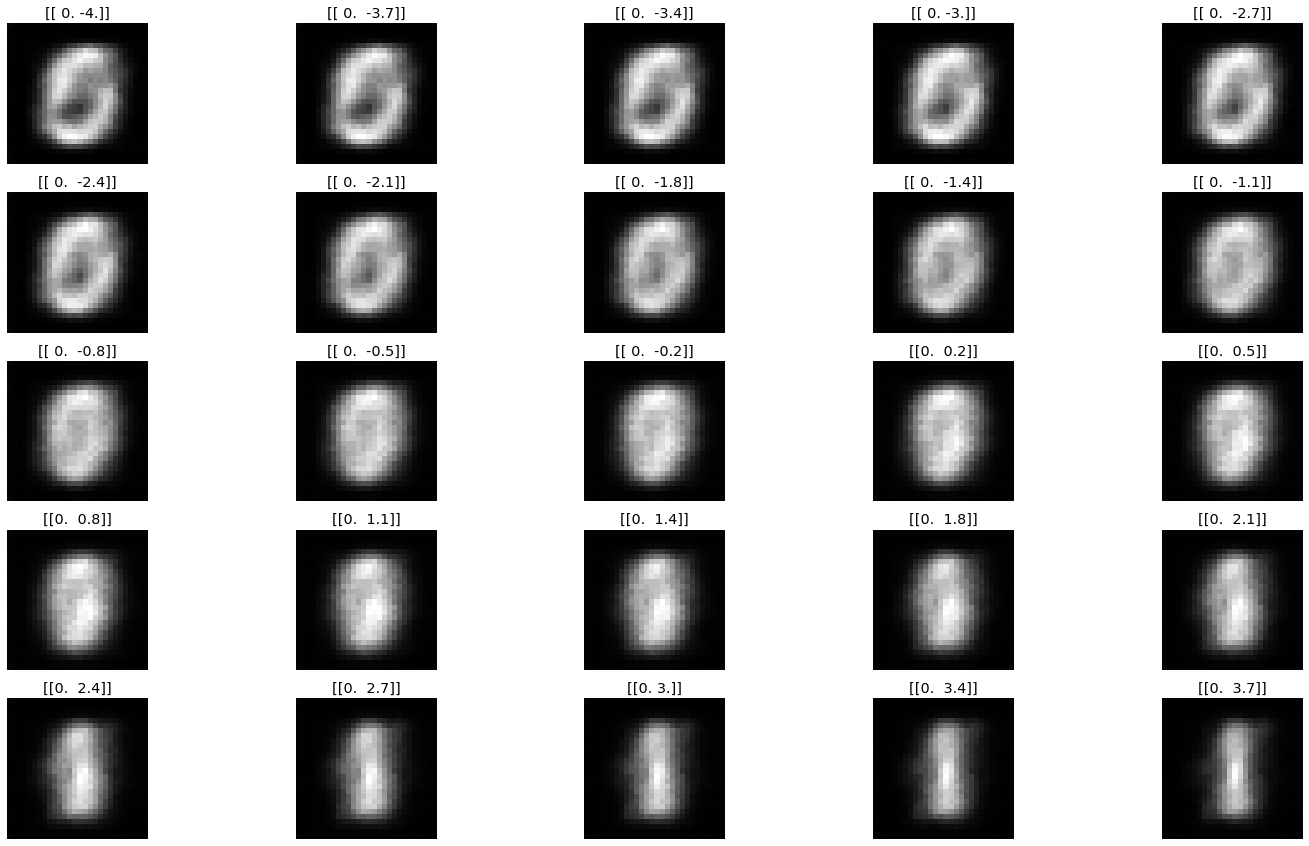

In [ ]:
fig = plt.figure(figsize=(25, 15))
num_samples = 25

pt1 = np.zeros((latent_size,))-0.5
pt2 = np.zeros((latent_size,))-0.5
pt1[0] = 0
pt1[1] = -4
pt2[0] = 0
pt2[1] = 4
vec = pt2 - pt1
step = 1/num_samples

for i in range (num_samples):
  pt = pt1 + vec * step * i
  pt = np.expand_dims(pt, axis=0)
  reconst = dec.predict(pt)

  ax = fig.add_subplot(5, 5, i+1)
  ax.axis('off')
  # ax.text(0.5, -0.15, str(np.round(pt,1)), fontsize=10, ha='center', transform=ax.transAxes)
  plt.title(str(np.round(pt,1)))
  ax.imshow(reconst[0, :, :, 0]*255, cmap = 'gray')
